### Apply Machine Learning to Match Outcome Retrodiction
### Part 2: Squawka Data

This study follows the same process as [Match Outcome Retrodiction with Kaggle European Soccer Database](https://github.com/xzl524/football_data_analysis/blob/master/projects/match_outcome_prediction/match_outcome_retrodiction_kaggle.ipynb). However, Football data from Squawka are used in this study.

### Conclusions

* Some model results are summarized below:

|                   Model      |    Accuracy( (with Squawka Dataset)   | Accuracy( (with Kaggle Dataset)
| :--------------------------------------------------:| :------------:| :---:|
| Random Guess                                    |    33.4%      |    34.2%  |
| Always Home Team Win                                  |    46.0%      |    46.0%  |
| Logistic Regression	                                             |    62.6%      |    56.6%  |
| Linear Discriminant Analysis                                         |    62.9%      |    56.6%  |
| Poisson Regression	                                             |    62.2%      |    56.0%  |
| Gradient Boosting                                             |    61.4%      |    56.4%  |
| Random Forest                                             |    62.7%      |    55.8%  |
| Neural Network                                             |    63.2%      |    56.2%  |

* Cross is ranked 3rd on the feature list, just behind goal attempt and set pieces.

### Table of Contents
#### 1. [Data Preprocessing](#preprocess)
#### 2. [Baseline Results](#baseline)
#### 3. [Model Selection](#model_selection)
#### 4. [Model Evaluation](#model_evaluation)

#### <a id='preprocess'></a>1. Data Preprocessing

In [1]:
%matplotlib inline
import pandas as pd
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

sns.set_style('white')
sns.set_context('poster')

#### Load dataset

In [2]:
# load match stats dataset
data_dir = os.path.join(os.path.pardir, os.path.pardir, 'data_source', 'squawka', 'match_stats_squawka_footballdata.csv')
match = pd.read_csv(data_dir, encoding='utf-8', low_memory=False)

#### Data preprocessing

In [3]:
match = match.rename(columns={'Date': 'date',
                              'HomeTeam': 'home_team',
                              'AwayTeam': 'away_team',
                              'FTHG': 'home_team_goal',
                              'FTAG': 'away_team_goal',
                              'HS': 'home_team_shot',
                              'AS': 'away_team_shot',
                              'HST': 'home_team_shoton',
                              'AST': 'away_team_shoton',
                              'HC': 'home_team_corner_footballdata',
                              'AC': 'away_team_corner_footballdata',
                              'HF': 'home_team_foul_footballdata',
                              'AF': 'away_team_foul_footballdata',
                              'HY': 'home_team_yellow_card',
                              'AY': 'away_team_yellow_card',
                              'HR': 'home_team_red_card',
                              'AR': 'away_team_red_card'})

# Extract home team's goal difference for each game
goal_diff = match['home_team_goal'] - match['away_team_goal']

# Encode match result
# home team win:  0
# home team draw: 1
# home team lose: 2
match['result'] = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

match.head()

,away_team_corner_footballdata,away_team_foul_footballdata,away_team_red_card,away_team_shot,away_team_shoton,away_team_yellow_card,away_team,B365A,B365D,B365H,...,away_team_corners,home_team_clearances,away_team_clearances,home_team_cards,away_team_cards,home_team_blocked_events,away_team_blocked_events,home_team_balls_out,away_team_balls_out,result
0,2.0,14.0,0.0,10.0,3.0,2.0,Werder Bremen,9.00,5.50,1.3,...,2.0,30.0,31.0,2.0,2.0,0.0,0.0,0.0,0.0,0
1,0.0,14.0,0.0,9.0,4.0,2.0,Fortuna Dusseldorf,3.60,3.50,2.0,...,0.0,5.0,29.0,3.0,2.0,0.0,0.0,0.0,0.0,2
2,7.0,22.0,0.0,19.0,10.0,2.0,Leverkusen,2.40,3.40,2.8,...,7.0,31.0,36.0,1.0,2.0,0.0,0.0,0.0,0.0,0
3,8.0,13.0,0.0,8.0,3.0,2.0,Mainz,2.75,3.30,2.5,...,8.0,38.0,45.0,0.0,2.0,0.0,0.0,0.0,0.0,1
4,4.0,13.0,0.0,19.0,9.0,2.0,Bayern Munich,1.36,4.75,8.5,...,4.0,20.0,13.0,2.0,2.0,0.0,0.0,0.0,0.0,2


#### Select modeling features

In [4]:
# Select event types
events = ['takeons', 'tackles', 'setpieces', 'offside', 'keepersweeper', 'interceptions', 'headed_duals', 'goal_keeping',
          'goals_attempts', 'fouls', 'crosses', 'corners', 'clearances', 'cards', 'blocked_events', 'balls_out']
event_features = ['home_team_{}'.format(i) for i in events] + ['away_team_{}'.format(i) for i in events]

# Select features
feature_list = event_features
print(feature_list)

['home_team_takeons', 'home_team_tackles', 'home_team_setpieces', 'home_team_offside', 'home_team_keepersweeper', 'home_team_interceptions', 'home_team_headed_duals', 'home_team_goal_keeping', 'home_team_goals_attempts', 'home_team_fouls', 'home_team_crosses', 'home_team_corners', 'home_team_clearances', 'home_team_cards', 'home_team_blocked_events', 'home_team_balls_out', 'away_team_takeons', 'away_team_tackles', 'away_team_setpieces', 'away_team_offside', 'away_team_keepersweeper', 'away_team_interceptions', 'away_team_headed_duals', 'away_team_goal_keeping', 'away_team_goals_attempts', 'away_team_fouls', 'away_team_crosses', 'away_team_corners', 'away_team_clearances', 'away_team_cards', 'away_team_blocked_events', 'away_team_balls_out']


#### Prepare modeling data

In [5]:
# Remove null-data matches
match_sel = match
for col in feature_list + ['result', 'home_team_goal', 'away_team_goal']:
    match_sel = match_sel[match_sel[col].notnull()]
    
# Train test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(match_sel, test_size=1000, random_state=42)

Xtrain = train_df[feature_list].values
Xtest = test_df[feature_list].values

y = match_sel['result'].values
ytrain = train_df['result'].values
ytest = test_df['result'].values

hgoaltrain = train_df['home_team_goal'].values
hgoaltest = test_df['home_team_goal'].values

agoaltrain = train_df['away_team_goal'].values
agoaltest = test_df['away_team_goal'].values

In [6]:
# Normalize the inputs
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

Xtrain_norm = mms.fit_transform(Xtrain)
Xtest_norm = mms.transform(Xtest)

In [7]:
print('total data size:                                      {}'.format(match_sel.shape[0]))
print('train data size (include cross validation data):      {}'.format(Xtrain_norm.shape[0]))
print('test data size:                                       {}'.format(Xtest_norm.shape[0]))

total data size:                                      10734
train data size (include cross validation data):      9734
test data size:                                       1000


#### <a id='baseline'></a>2. Baseline Results

#### 2.1 Random Guess

In [9]:
# random guess
np.random.seed(42)
y_pred = np.random.choice([0,1,2], len(y))
print('Random Guess')
print('Prediction Accuracy: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

Random Guess
Prediction Accuracy: 33.4%


#### 2.2 Always Home Team Win

In [10]:
# Always predicting home team win
y_pred = np.zeros(len(y))
print('Always Home Team Win')
print('Prediction Accuracy: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

Always Home Team Win
Prediction Accuracy: 45.8%


#### 2.3 Always Draw

In [11]:
# Always predicting draw
y_pred = np.ones(len(y))
print('Always Draw')
print('Prediction Accuracy: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

Always Draw
Prediction Accuracy: 24.9%


#### 2.4 Always Home Team Lose

In [12]:
# Always predicting home team lose
y_pred = 2*np.ones(len(y))
print('Always Home Team Lose')
print('Prediction Accuracy: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

Always Home Team Lose
Prediction Accuracy: 29.3%


#### <a id='model_selection'></a>3. Model Selection

#### Logistic Regression/Gradient Boosting/Random Forest

In [13]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}

# Gradient Boosting
#from sklearn.ensemble import GradientBoostingClassifier
#clf = GradientBoostingClassifier(max_depth=4, n_estimators=90)
#parameter_dic= {"n_estimators": range(50, 150, 10)}

# Random Forest
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(max_features=11, n_estimators=100)
#parameter_dic= {'n_estimators':range(100, 250, 10)}

Apply cross validation for hyper-parameter tuning.

In [14]:
# Plot validation curve using default prediction accuracy
from sklearn.model_selection import validation_curve
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain_norm,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

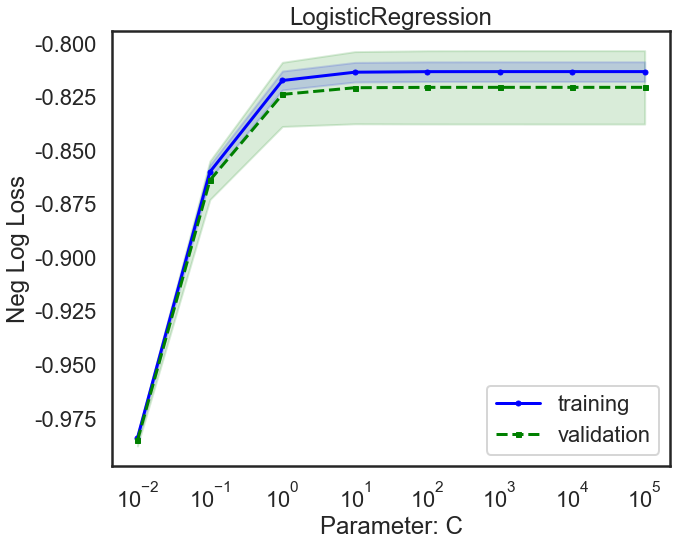

Best C:               1000
Neg. log loss (train): -0.8133
Neg. log loss (cv):    -0.8206


In [15]:
plt.figure(figsize=(10,8))
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),train_mean,
         color='blue',marker='o',
         markersize=5,label='training')
plt.fill_between(parameter_dic.get(list(parameter_dic.keys())[0]),
                 train_mean+train_std,
                 train_mean-train_std,
                 alpha=0.15,color='blue')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='validation')
plt.fill_between(parameter_dic.get(list(parameter_dic.keys())[0]),
                 test_mean+test_std,
                 test_mean-test_std,
                 alpha=0.15,color='green')
plt.xlabel('Parameter: {}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('Neg Log Loss')
plt.legend(loc='lower right')
plt.title('{}'.format(clf.__class__.__name__))
if clf.__class__.__name__ == 'LogisticRegression':
    plt.xscale('log')
plt.show()

# print best cross validation result
print('Best {}:               {}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('Neg. log loss (train): {:.4f}'.format(train_mean[np.argmax(test_mean)]))
print('Neg. log loss (cv):    {:.4f}'.format(np.max(test_mean)))

#### LDA (Linear Discriminant Analysis)

train average:            0.8220
cross validation average: 0.8276


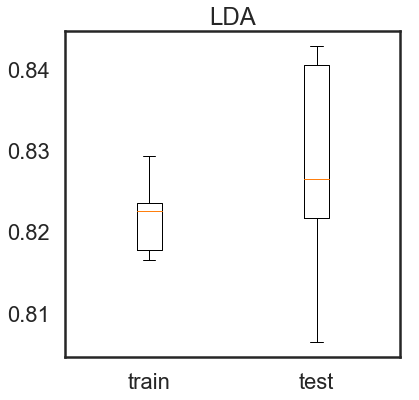

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()

cross_validation_fold = 5

train_scores = []
test_scores = []

kf = StratifiedKFold(n_splits=cross_validation_fold, shuffle=False)
    
for train, test in kf.split(Xtrain_norm, ytrain):
    
    clf.fit(Xtrain_norm[train], ytrain[train])
    train_scores.append(log_loss(ytrain[train], clf.predict_proba(Xtrain_norm[train])))
    test_scores.append(log_loss(ytrain[test], clf.predict_proba(Xtrain_norm[test])))

plt.figure(figsize=(6,6))
plt.boxplot([train_scores, test_scores], labels=['train','test'])
plt.title('LDA')
print('train average:            {:.4f}'.format(np.mean(train_scores)))
print('cross validation average: {:.4f}'.format(np.mean(test_scores)))

#### Poisson Regression

train average:            0.8543
cross validation average: 0.8557


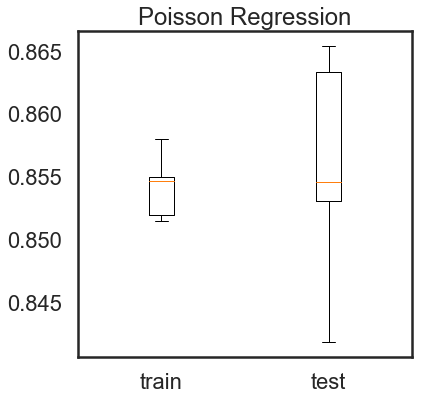

In [21]:
from footballmodels import PoissonRegression
clf = PoissonRegression()

cross_validation_fold = 5

train_scores = []
test_scores = []

kf = StratifiedKFold(n_splits=cross_validation_fold, shuffle=False)
    
for train, test in kf.split(Xtrain_norm, ytrain):
    
    clf.fit(Xtrain_norm[train], Xtrain_norm[train], hgoaltrain[train], agoaltrain[train])
    train_scores.append(log_loss(ytrain[train], clf.predict_proba(Xtrain_norm[train], Xtrain_norm[train])))
    test_scores.append(log_loss(ytrain[test], clf.predict_proba(Xtrain_norm[test], Xtrain_norm[test])))

plt.figure(figsize=(6,6))
plt.boxplot([train_scores, test_scores], labels=['train','test'])
plt.title('Poisson Regression')
print('train average:            {:.4f}'.format(np.mean(train_scores)))
print('cross validation average: {:.4f}'.format(np.mean(test_scores)))

#### Neural Network

In [22]:
import tensorflow as tf
from tensorflow import keras

In [23]:
# Train validation split
train_x, val_x, train_y, val_y = train_test_split(Xtrain_norm, ytrain, test_size=1000, stratify=ytrain, random_state=42)

In [24]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(Xtrain_norm.shape[1],), ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.8),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.train.AdamOptimizer(),
                  metrics=['accuracy'])
    
    return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_x, train_y, epochs=100,
                    validation_data=(val_x, val_y), verbose=0)

The train acc for last epoch is 61.40%
The train loss for last epoch is 0.845
The val acc for last epoch is 59.90%
The val loss for last epoch is 0.838


(0.8, 1)

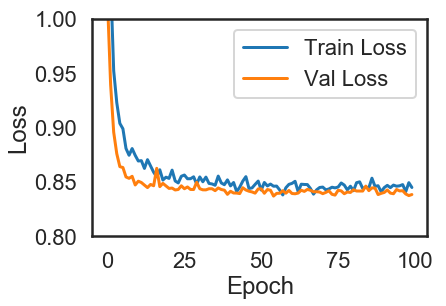

In [27]:
def plot_history(history, kind='acc'):
    plt.figure()
    plt.xlabel('Epoch')
    if kind == 'acc':
        plt.ylabel('Accuracy')
        plt.plot(history.epoch, np.array(history.history['acc']),
                 label='Train Acc')
        plt.plot(history.epoch, np.array(history.history['val_acc']),
                 label = 'Val Acc')
        plt.legend()
    elif kind == 'loss':
        plt.ylabel('Loss')
        plt.plot(history.epoch, np.array(history.history['loss']),
                 label='Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']),
                 label = 'Val Loss')
        plt.legend()


print('The train acc for last epoch is {:.2f}%'.format(history.history['acc'][-1]*100))
print('The train loss for last epoch is {:.3f}'.format(history.history['loss'][-1]))

print('The val acc for last epoch is {:.2f}%'.format(history.history['val_acc'][-1]*100))
print('The val loss for last epoch is {:.3f}'.format(history.history['val_loss'][-1]))

plot_history(history, kind='loss')
plt.ylim(0.8, 1)

#### <a id='model_evaluation'></a>4. Model Evaluation

#### 4.1 Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
best_clf = LogisticRegression(C=1000, multi_class='auto', solver='liblinear')

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)

# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### Model Evaluation
print('Model Evaluation ({})'.format(best_clf.__class__.__name__))
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (LogisticRegression)
Log Loss:                   0.8273
Prediction Accuracy:        62.6%


#### 4.2 LDA

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
best_clf = LinearDiscriminantAnalysis()

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)

# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### Model Evaluation
print('Model Evaluation ({})'.format(best_clf.__class__.__name__))
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (LinearDiscriminantAnalysis)
Log Loss:                   0.8331
Prediction Accuracy:        62.9%


#### 4.3 Poisson Regression

In [32]:
from footballmodels import PoissonRegression
best_clf = PoissonRegression()

# Fit the data to build model
best_clf.fit(Xtrain_norm, Xtrain_norm, hgoaltrain, agoaltrain)

# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm, Xtest_norm)

#### Model Evaluation
print('Model Evaluation (Poisson Regression)')
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (Poisson Regression)
Log Loss:                   0.8601
Prediction Accuracy:        62.2%


#### Feature Interpretation

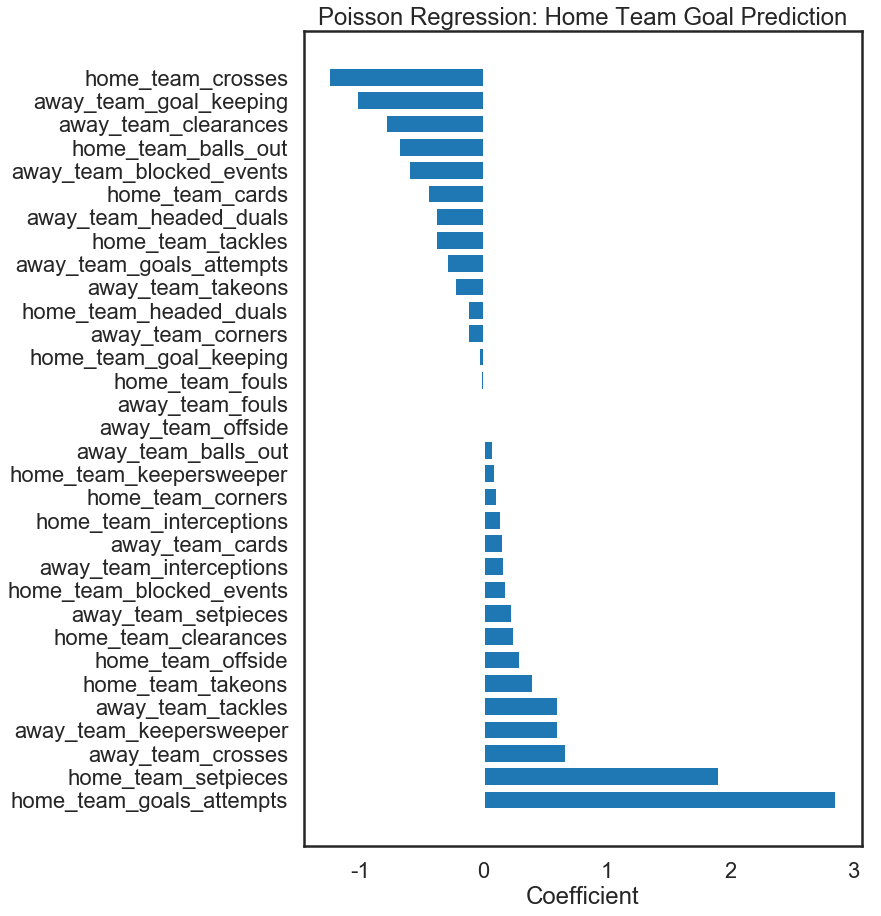

In [34]:
encoded_home_feature_list = feature_list
importance_list, name_list = zip(*sorted(zip(best_clf.hgoal_reg.params, encoded_home_feature_list),reverse=True))

plt.figure(figsize=(10,15))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list)
plt.xlabel('Coefficient')
plt.title('Poisson Regression: Home Team Goal Prediction')
#plt.xlim(-1,1)
plt.show()

For home team goal, most 3 related features are: home team goal attempt, home team set piece, and home team cross.

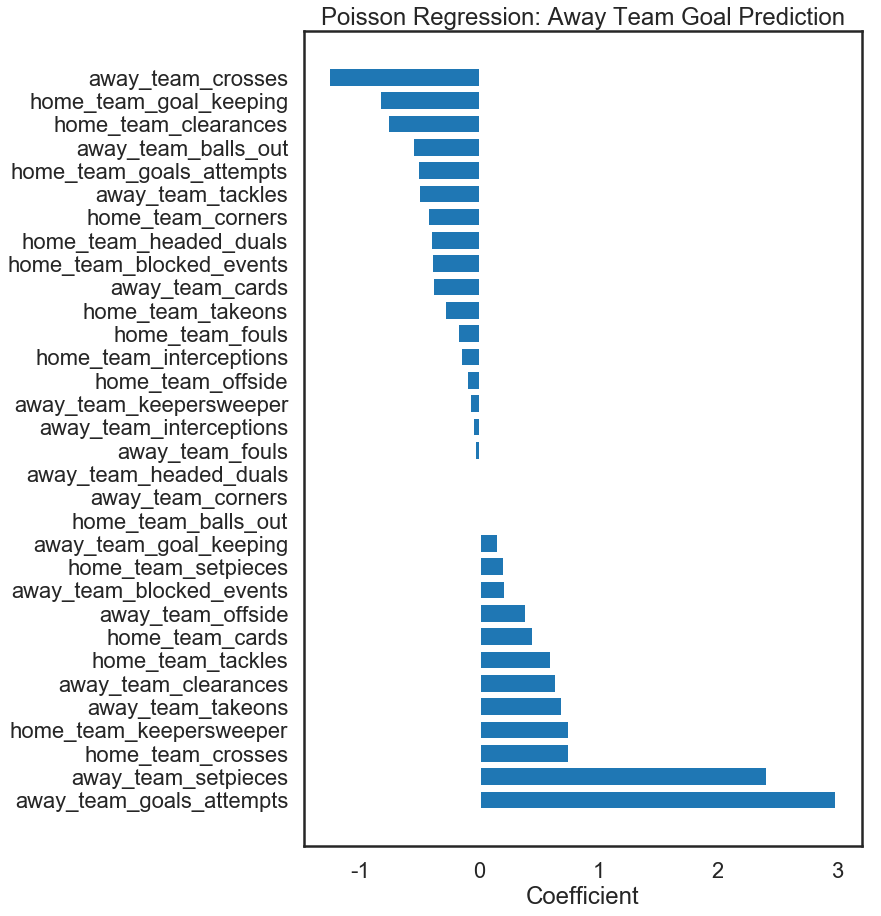

In [35]:
encoded_away_feature_list = feature_list
importance_list, name_list = zip(*sorted(zip(best_clf.agoal_reg.params, encoded_away_feature_list),reverse=True))

plt.figure(figsize=(10,15))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list)
plt.xlabel('Coefficient')
plt.title('Poisson Regression: Away Team Goal Prediction')
#plt.xlim(-1,1)
plt.show()

For away team goal, most 3 related features are: away team goal attempt, away team set piece, and away team cross.

#### 4.4 Gradient Boosting

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
best_clf = GradientBoostingClassifier(max_depth=3, n_estimators=140)

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)

# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### Model Evaluation
print('Model Evaluation ({})'.format(best_clf.__class__.__name__))
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (GradientBoostingClassifier)
Log Loss:                   0.8290
Prediction Accuracy:        61.4%


#### Feature Interpretation

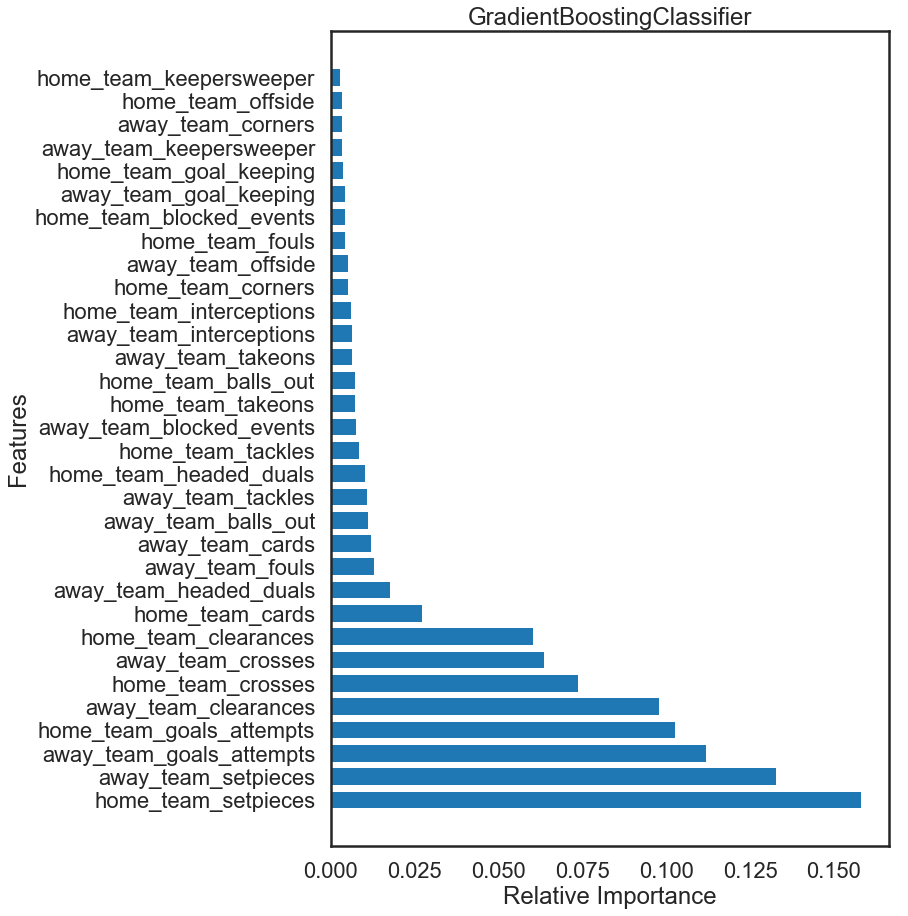

In [38]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list),reverse=True))
plt.figure(figsize=(10,15))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('{}'.format(best_clf.__class__.__name__))
plt.show()

#### 4.5 Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
best_clf = RandomForestClassifier(max_features=11, n_estimators=230)

# Fit the data to build model
best_clf.fit(Xtrain_norm, ytrain)

# Output probability estimation
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### Model Evaluation
print('Model Evaluation ({})'.format(best_clf.__class__.__name__))
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (RandomForestClassifier)
Log Loss:                   0.8799
Prediction Accuracy:        62.7%


#### Feature Interpretation

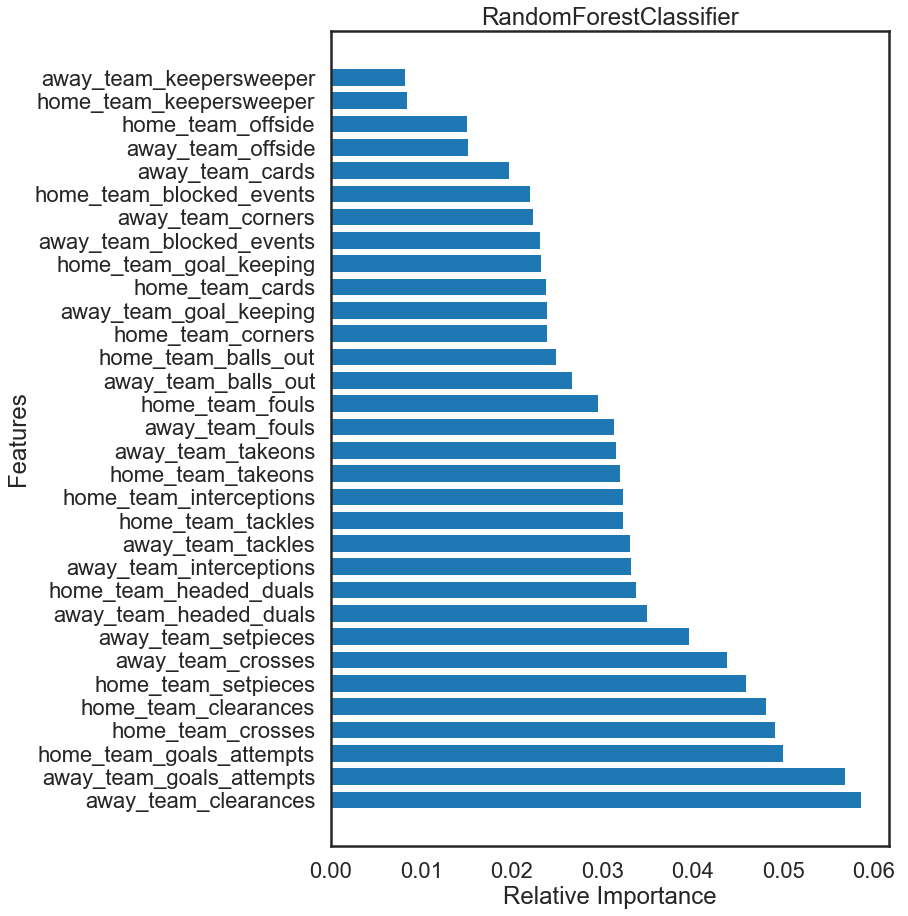

In [68]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list),reverse=True))
plt.figure(figsize=(10,15))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('{}'.format(best_clf.__class__.__name__))
plt.show()

#### 4.6 Neural Network

In [41]:
# Fit the data to build model
model.fit(Xtrain_norm, ytrain, epochs=100, verbose=0)

# Output probability estimation
ytest_prob = model.predict_proba(Xtest_norm)

#### Model Evaluation
print('Model Evaluation (Neural Network)')
print('Log Loss:                   {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction Accuracy:        {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model Evaluation (Neural Network)
Log Loss:                   0.8106
Prediction Accuracy:        63.2%
